In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [3]:
dataset_folder = os.path.join("put_jetbot_dataset", "dataset")
print(os.listdir(dataset_folder))

['1652875851.3497071', '1652875851.3497071.csv', '1652875901.3107166', '1652875901.3107166.csv', '1652876013.741493', '1652876013.741493.csv', '1652876206.2541456', '1652876206.2541456.csv', '1652876485.8123376', '1652876485.8123376.csv', '1652959186.4507334', '1652959186.4507334.csv', '1652959347.972946', '1652959347.972946.csv', '1653042695.4914637', '1653042695.4914637.csv', '1653042775.5213027', '1653042775.5213027.csv', '1653043202.5073502', '1653043202.5073502.csv', '1653043345.3415065', '1653043345.3415065.csv', '1653043428.8546412', '1653043428.8546412.csv', '1653043549.5187616', '1653043549.5187616.csv']


In [4]:
X = []
y = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")

        X.append(img_path)
        y.append([forward, left])

X = np.array(X)
y = np.array(y, dtype=np.float32)

X.shape, y.shape

((7584,), (7584, 2))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [6]:
class JetBotImageDataset(Dataset):
    def __init__(self, image_paths, image_ys, transform=None):
        self.image_paths = image_paths
        self.image_ys = image_ys
        self.transform = transform

        assert len(image_paths) == len(image_ys)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.image_ys[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transform = v2.Compose([
    v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.75, 1.25)),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
train_dataset = JetBotImageDataset(X_train, y_train, transform)
test_dataset = JetBotImageDataset(X_test, y_test, transform)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [10]:
train_features, train_labels = next(iter(test_dataloader))

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

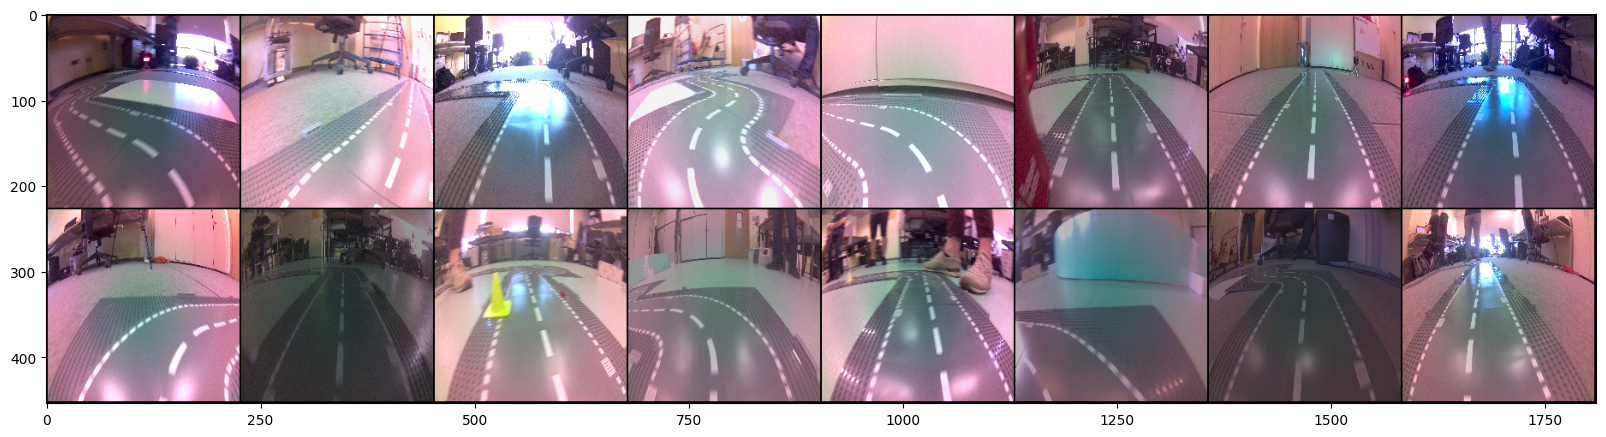

In [12]:
imshow(torchvision.utils.make_grid(train_features))

In [13]:
class SteeringCNN(nn.Module):
    def __init__(self):
        super(SteeringCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.forward_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        self.left_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        forward = self.forward_layers(x)
        left = self.left_layers(x)
        return torch.cat((forward, left), dim=1)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [15]:
net = SteeringCNN()
net.to(device)

SteeringCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (forward_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (left_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [16]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 50
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    return last_loss

In [18]:
for epoch in range(3):
    print('EPOCH {}:'.format(epoch + 1))
    
    net.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    net.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
            

EPOCH 1:
  batch 50 loss: 0.2500237876176834
  batch 100 loss: 0.22104571133852005
  batch 150 loss: 0.22556440263986588
  batch 200 loss: 0.2356848008930683
  batch 250 loss: 0.24007025986909866
  batch 300 loss: 0.2238667081296444
  batch 350 loss: 0.24879278421401976
LOSS train 0.24879278421401976 valid 0.22691600024700165
EPOCH 2:
  batch 50 loss: 0.23382433876395226
  batch 100 loss: 0.21716172866523265
  batch 150 loss: 0.22350408375263214
  batch 200 loss: 0.23117265045642854
  batch 250 loss: 0.23700672298669814
  batch 300 loss: 0.22368787065148354
  batch 350 loss: 0.2487095245718956
LOSS train 0.2487095245718956 valid 0.22805994749069214
EPOCH 3:
  batch 50 loss: 0.23028676271438597
  batch 100 loss: 0.21553810492157935
  batch 150 loss: 0.22198391303420067
  batch 200 loss: 0.2318225759267807
  batch 250 loss: 0.23427860036492348
  batch 300 loss: 0.22192239493131638
  batch 350 loss: 0.24531018406152724
LOSS train 0.24531018406152724 valid 0.22994334995746613


In [21]:
sum(p.numel() for p in net.parameters())

1606170

In [22]:
import torch.onnx

x = torch.randn(32, 3, 224, 224, requires_grad=True)

torch.onnx.export(net, x, 'test.onnx', export_params=True, opset_version=11)

# Smaller model proposition

In [23]:
class SmallerCNN(nn.Module):
    def __init__(self):
        super(SmallerCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*7*7, 64),  
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [24]:
sm_net = SmallerCNN()
sm_net.to(device)

SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12544, out_feature

In [27]:
# training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(sm_net.parameters(), lr=0.001)

In [28]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = sm_net(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 50
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    return last_loss

In [29]:
sum(p.numel() for p in sm_net.parameters())

1195618

In [30]:
for epoch in range(20):
    print('EPOCH {}:'.format(epoch + 1))
    
    sm_net.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    sm_net.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = sm_net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

EPOCH 1:
  batch 50 loss: 0.25878066137433053
  batch 100 loss: 0.22513710215687752
  batch 150 loss: 0.22878859482705594
  batch 200 loss: 0.2399621108174324
  batch 250 loss: 0.24768398061394692
  batch 300 loss: 0.2258090853691101
  batch 350 loss: 0.2518130815029144
LOSS train 0.2518130815029144 valid 0.2296093851327896
EPOCH 2:
  batch 50 loss: 0.23915224969387056
  batch 100 loss: 0.2222457517683506
  batch 150 loss: 0.22598916351795195
  batch 200 loss: 0.23768836244940758
  batch 250 loss: 0.22022545620799064
  batch 300 loss: 0.1250433664023876
  batch 350 loss: 0.15238869816064834
LOSS train 0.15238869816064834 valid 0.1144084483385086
EPOCH 3:
  batch 50 loss: 0.12344400033354759
  batch 100 loss: 0.12038152597844601
  batch 150 loss: 0.11997766934335231
  batch 200 loss: 0.10992084696888924
  batch 250 loss: 0.10425767466425896
  batch 300 loss: 0.08394181054085494
  batch 350 loss: 0.11885953031480312
LOSS train 0.11885953031480312 valid 0.09817974269390106
EPOCH 4:
  batc

In [31]:
# export as onnx with OPSET 11
x = torch.randn(32, 3, 224, 224, requires_grad=True)
torch.onnx.export(sm_net, x, 'smaller_cnn_1p2m.onnx', export_params=True, opset_version=11)

# Can we go even smaller?

In [32]:
class EvenSmallerCNN(nn.Module):
    def __init__(self):
        super(EvenSmallerCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   
        )

        self.fc_layers_forward = nn.Sequential(
            nn.Linear(128*7*7, 32),  
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )
        self.fc_layers_left = nn.Sequential(
            nn.Linear(128*7*7, 32),  
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        forward = self.fc_layers_forward(x)
        left = self.fc_layers_left(x)
        return torch.cat((forward, left), dim=1)

In [33]:
model = EvenSmallerCNN()
print(sum(p.numel() for p in model.parameters()))

499922


In [34]:
# training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 50
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    return last_loss

In [36]:
for epoch in range(20):
    print('EPOCH {}:'.format(epoch + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

EPOCH 1:
  batch 50 loss: 0.26606643810868263
  batch 100 loss: 0.2250174590945244
  batch 150 loss: 0.2263215459883213
  batch 200 loss: 0.23802677109837533
  batch 250 loss: 0.24266537502408028
  batch 300 loss: 0.22535523355007173
  batch 350 loss: 0.25114391386508944
LOSS train 0.25114391386508944 valid 0.23224355280399323
EPOCH 2:
  batch 50 loss: 0.2365614452958107
  batch 100 loss: 0.2220076924562454
  batch 150 loss: 0.22579981438815594
  batch 200 loss: 0.2368623335659504
  batch 250 loss: 0.24212560802698135
  batch 300 loss: 0.22531594902276994
  batch 350 loss: 0.25129653841257094
LOSS train 0.25129653841257094 valid 0.22856715321540833
EPOCH 3:
  batch 50 loss: 0.23561030492186547
  batch 100 loss: 0.221193270906806
  batch 150 loss: 0.22607628732919693
  batch 200 loss: 0.2367812404036522
  batch 250 loss: 0.2418820957839489
  batch 300 loss: 0.2254386268556118
  batch 350 loss: 0.2512726417183876
LOSS train 0.2512726417183876 valid 0.22859452664852142
EPOCH 4:
  batch 50

In [37]:
# onnx export
x = torch.randn(32, 3, 224, 224, requires_grad=True)
torch.onnx.export(model, x, 'even_smaller_cnn_0p5m.onnx', export_params=True, opset_version=11)